# 영화 평점 점수 데이터 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
metadata = pd.read_csv('IMDB-Movie-Data.csv')
metadata.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [28]:
metadata.shape

(1000, 12)

In [10]:
metadata['Rating'].mean()

6.723199999999999

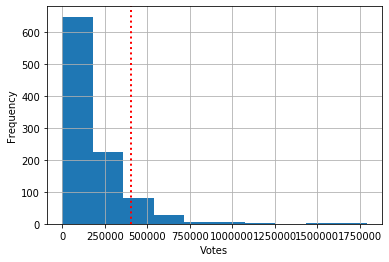

In [23]:
metadata['Votes'].plot.hist()
plt.axvline(metadata['Votes'].quantile(.9), color='r', linestyle=':', linewidth=2)
plt.xlabel('Votes')
plt.grid(True); plt.show()

In [29]:
metadata.loc[metadata['Votes'] < metadata['Votes'].quantile(.9)].shape

(900, 12)

In [27]:
metadata.loc[metadata['Votes'] >= metadata['Votes'].quantile(.9)].shape

(100, 12)

In [36]:
C = metadata['Rating'].mean() # 전체 영화의 평균 평점
R = metadata['Rating'].copy() # 각 영화의 평균 평점
m = metadata['Votes'].quantile(.9) # 차트에 등장하기 위한 최소의 평가자 수 ## Hyperparameter
v = metadata['Votes'].copy() # 평가자 수

In [40]:
C, m

(6.723199999999999, 406251.10000000003)

In [45]:
metadata['score'] = (v / (v + m)) * R + (m / (v + m)) * C

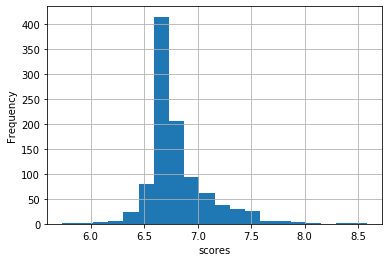

In [51]:
metadata['score'].plot.hist(bins=20)
plt.xlabel('scores'), plt.grid(True); plt.show()

In [54]:
col = ['Title', 'Rating', 'Votes', 'score']
rs_original = metadata.sort_values('Rating', ascending=False)[col]
rs_new = metadata.sort_values('score', ascending=False)[col]

In [56]:
rs_original.head()

,Title,Rating,Votes,score
54,The Dark Knight,9.0,1791916,8.579216
80,Inception,8.8,1583625,8.376003
117,Dangal,8.8,48969,6.946606
36,Interstellar,8.6,1047747,8.075617
96,Kimi no na wa,8.6,34110,6.868575


In [59]:
rs_new.head()

,Title,Rating,Votes,score
54,The Dark Knight,9.0,1791916,8.579216
80,Inception,8.8,1583625,8.376003
36,Interstellar,8.6,1047747,8.075617
124,The Dark Knight Rises,8.5,1222645,8.056861
99,The Departed,8.5,937414,7.962793


- 영화 Description의 유사도를 계산하여 추천

In [60]:
metadata['Description'].iloc[0]

'A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.'

In [61]:
metadata['Description'].head()

0    A group of intergalactic criminals are forced ...
1    Following clues to the origin of mankind, a te...
2    Three girls are kidnapped by a man with a diag...
3    In a city of humanoid animals, a hustling thea...
4    A secret government agency recruits some of th...
Name: Description, dtype: object

- TF-IDF 계산

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

metadata.Description = metadata.Description.fillna('')
tfidf_matrix = tfidf.fit_transform(metadata.Description)

tfidf_matrix.shape

(1000, 5667)

In [65]:
tfidf_matrix.

<1000x5667 sparse matrix of type '<class 'numpy.float64'>'
	with 14873 stored elements in Compressed Sparse Row format>

### TF-IDF 유사도 계산 
- 벡터화된 데이터의 경우 Cosine 유사도가 성능이 제일 좋음
$$cosine(x,y)=\frac{x{\cdot}y^{T}}{||x||{\cdot}||y||}$$
- 벡터화된 데이터의 경우 Cosine 유사도가 성능이 제일 좋음
- Tf-IDF의 경우 내적만 구해도 가능
    - sklearn의 `cosine_similarities()` 대신에 `linear_kernel()`을 사용

In [71]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.04963063],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.04963063, 0.        , ..., 0.        , 0.        ,
        1.        ]])

### 추천 리스트 생성
- 가장 유사한 10개 영화를 추천 리스트로 생성
    1. 영화 타이틀을 인덱스화
    2. 인덱스를 기준으로 유사도 추출
    3. 유사도 기준 10개 영화 선정
    4. 인덱스를 영화 타이틀로 변환

1. 영화 타이틀을 인덱스화

In [100]:
indices = pd.Series(data=metadata.index, index=metadata['Title']).drop_duplicates() # 중복 없음

2. 인덱스를 기준으로 유사도 추출

In [101]:
indices.index[77]

'Inglourious Basterds'

In [102]:
title = indices.index[77]
idx = indices[title]
sim_score = list(enumerate(cosine_sim[idx])) # same to [(ix, score) for ix, score in cosine_sim[idx]]
                                             # 인덱스를 기준으로 유사도 추출
sim_score = sorted(sim_score, key=lambda x : x[1], reverse=True) # 코사인 유사도가 높은 순으로 정렬

In [103]:
sim_score[:10] # 상위 10개 보여줌

[(77, 1.0),
 (820, 0.2194708587904979),
 (424, 0.17742872061971435),
 (328, 0.14724781612112411),
 (293, 0.12178966106663505),
 (177, 0.11862926185914657),
 (872, 0.11629092707642368),
 (220, 0.11030709295069732),
 (198, 0.10512753880505245),
 (809, 0.09471333122530248)]

3. 유사도 기준 10개 영화 선정

In [104]:
n = 10
sim_score = sim_score[1 : n + 1] # 10개 선정
movie_index = [i[0] for i in sim_score] # 유사도 기준 영화 선정
movie_index

[820, 424, 328, 293, 177, 872, 220, 198, 809, 920]

4. 인덱스를 영화 타이틀로 변환

In [105]:
metadata.Title.iloc[movie_index]

820                     Suite Française
424                   London Has Fallen
328                          Green Room
293                       The Exception
177                      Tropic Thunder
872                            Red Dawn
220                      Hardcore Henry
198                  The Imitation Game
809    USS Indianapolis: Men of Courage
920                           Centurion
Name: Title, dtype: object

#### 함수화

In [106]:
def rs(title, n, sim):
    idx = indices[title]
    sim_score = list(enumerate(cosine_sim[idx]))
    sim_score = sorted(sim_score, key=lambda x : x[1], reverse=True)
    sim_score = sim_score[1 : n + 1]
    movie_index = [i[0] for i in sim_score]
    return metadata.Title.iloc[movie_index]

In [108]:
rs('The Dark Knight Rises', n=10, sim=cosine_sim)

54              The Dark Knight
144            Django Unchained
522                      Viking
471            Marie Antoinette
254               The Conjuring
920                   Centurion
253    The Amazing Spider-Man 2
604       The Rise of the Krays
615                Bastille Day
915                     Goksung
Name: Title, dtype: object

In [109]:
rs('Suicide Squad', n=5, sim=cosine_sim)

153                         Sicario
676                     Escape Plan
32                X-Men: Apocalypse
65     Kingsman: The Secret Service
552                  Fantastic Four
Name: Title, dtype: object